In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import pickle as pkl
from torchvision import models, transforms, io
from torch.utils.data import Dataset, DataLoader
import utils
import os

## Data Loading

In [3]:
DATASET_PATH = '../ADE20K_2021_17_01/'
index_file = 'index_ade20k.pkl'
with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
    index_ade20k = pkl.load(f)

In [4]:
objects_mat = index_ade20k['objectPresence']

In [5]:
# Find 150 most common object IDs and non-common object IDs
total_object_counts = np.sum(objects_mat, axis=1)
object_count_ids = np.argsort(total_object_counts)[::-1]
most_common_obj_ids = object_count_ids[:150]
irrelevant_obj_ids = object_count_ids[150:]

In [216]:
most_common_obj_ids

array([3049, 2977, 1830, 2854,  311,  773,  470,  400, 1909,  975, 2419,
       1450, 3054, 1734,  446, 2683,  349, 1432, 1179, 1394, 2379,  688,
        235, 2130, 2376,  788, 1447, 2615,  686, 2310, 1379,  265, 1124,
       3034, 1745, 1609,  837,  248,   53, 2137, 2328, 2271,   82, 1205,
       1980,  579, 2508, 1237, 1563,   56,  977,  906,  164, 2931, 2275,
       1868,  580, 1097, 1935, 1918, 2472, 2242,  100, 2981, 2121,  135,
         85, 2177, 2116,  883, 2052, 1427,  258, 2387,  180, 1430, 2119,
       2813, 1212, 1275, 1743, 1438, 3086, 2699,   94, 2050,  723, 2529,
        145, 2263,  894, 1973, 2577, 2820,  570,  981, 1211, 2835, 2585,
       1624, 1348,   76, 1328, 2369, 1929, 2367, 2154,  529, 2678,   41,
         63, 3056, 2422,  222,  953, 1614,  377, 2993, 1755, 1787,  912,
       2118,  102,  782,  479, 1023, 2675,  211,  119, 2927, 1001, 2272,
        917, 2732, 1032,  136, 2530, 2849, 1968, 2340,  729, 2249, 1429,
       2345, 2832, 2900, 2879,  775, 1085,  319])

In [7]:
# Find image IDs where no irrelevant objects appear
irrelevant_obj_counts = np.sum(objects_mat[irrelevant_obj_ids], axis=0)
good_image_ids = np.argwhere(irrelevant_obj_counts == 0).flatten()

In [8]:
good_image_ids

array([   41,    74,   105, ..., 27550, 27556, 27573])

In [9]:
# Only common objects included
common_objects_mat = objects_mat[np.ix_(most_common_obj_ids, good_image_ids)]

In [10]:
train_image_ids = []
validation_image_ids = []

for i in good_image_ids:
    if 'training' in index_ade20k['folder'][i]:
        train_image_ids.append(i)
    elif 'validation' in index_ade20k['folder'][i]:
        validation_image_ids.append(i)
    else:
        raise Exception('Invalid folder name.')

In [239]:
class SegmentationDataset(Dataset):
    def __init__(self, image_ids, root_dir, index_mat, transform=None, target_transform=None):
        """
        Args:
            image_ids (list): list of image IDs from ADE20K
            root_dir (string): Directory with all the images.
            index_mat (array): object array from index_ade20k.pkl
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_transform (callable, optional): Optional transform to be applied
                on a sample segmentation label.
        """
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.index_ade20k = index_mat
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_name = os.path.join(self.root_dir, self.index_ade20k['folder'][image_id], 
                                self.index_ade20k['filename'][image_id])
        img_info = utils.loadAde20K(img_name)
        
        image = io.read_image(img_info['img_name']).float()
        class_mask = Image.fromarray(img_info['class_mask'], mode='I')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(class_mask)
            
        sample = (image, label)

        return sample

In [241]:
input_size = 224
transform = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
#                 transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

target_transform = transforms.Compose([
                transforms.Resize(input_size, interpolation=0),
                transforms.CenterCrop(input_size),
                transforms.ToTensor()
            ])

In [293]:
training_data = SegmentationDataset(train_image_ids[:4], '../', index_ade20k, transform=transform, target_transform=target_transform)

In [294]:
train_dataloader = DataLoader(training_data, batch_size=2, shuffle=False)

Feature batch shape: torch.Size([5, 3, 224, 224])
Labels batch shape: torch.Size([5, 1, 224, 224])


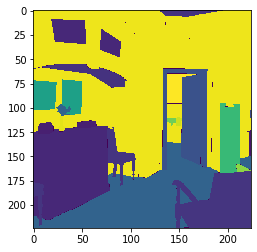

In [244]:
train_images, train_labels = next(iter(train_dataloader))
# print(train_images)
print(f"Feature batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_images[2].permute(1,2,0)
img /= img.max()
label = train_labels[2].squeeze()
# label /= label.max()
# plt.imshow(np.concatenate([img, label], 1))
# plt.imshow(img)
for num in label.flatten():
    obj_id = num.numpy() - 1
    if obj_id not in most_common_obj_ids and obj_id + 1 != 0:
        print("UH OH: ", obj_id) 
plt.imshow(label)

## EXAMPLE TEST

41
../ADE20K_2021_17_01/images/ADE/training/home_or_hotel/bathroom/ADE_train_00000042.jpg
[[   0    0    0 ... 2978 2978 2978]
 [   0    0  774 ... 2978 2978 2978]
 [   0    0  774 ... 2978 2978 2978]
 ...
 [   0    0 2978 ... 2978 2978 2978]
 [   0    0 2978 ... 2978 2978 2978]
 [   0    0    0 ...    0    0    0]]
(536, 402)


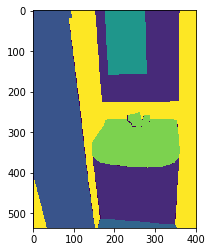

In [189]:
for i in train_image_ids[:1]:
    print(i)
#     print(index_ade20k['folder'][i], index_ade20k['filename'][i])
    full_file_name = '../{}/{}'.format(index_ade20k['folder'][i], index_ade20k['filename'][i])
    print(full_file_name)
    info = utils.loadAde20K(full_file_name)
#     img = cv2.imread(info['img_name'])[:,:,::-1]
#     seg = cv2.imread(info['segm_name'])[:,:,::-1]
    classmask = info['class_mask']
# #     seg_mask = seg.copy()

# #     The 0 index in seg_mask corresponds to background (not annotated) pixels
# #     seg_mask[info['class_mask'] != obj_id+1] *= 0
#     plt.figure(figsize=(10,5))

#     plt.imshow(np.concatenate([img, seg], 1))
#     plt.axis('off')
#     print(img.shape)
    print(classmask)
    print(classmask.shape)
    plt.imshow(classmask)
    

## Load model

In [229]:
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=151)

In [267]:
# Maps {obj_ids: 0-149}
obj_id_map = {sorted(most_common_obj_ids)[idx]: idx + 1 for idx in range(150)}
obj_id_map[-1] = 0

In [268]:
obj_id_map

{41: 1,
 53: 2,
 56: 3,
 63: 4,
 76: 5,
 82: 6,
 85: 7,
 94: 8,
 100: 9,
 102: 10,
 119: 11,
 135: 12,
 136: 13,
 145: 14,
 164: 15,
 180: 16,
 211: 17,
 222: 18,
 235: 19,
 248: 20,
 258: 21,
 265: 22,
 311: 23,
 319: 24,
 349: 25,
 377: 26,
 400: 27,
 446: 28,
 470: 29,
 479: 30,
 529: 31,
 570: 32,
 579: 33,
 580: 34,
 686: 35,
 688: 36,
 723: 37,
 729: 38,
 773: 39,
 775: 40,
 782: 41,
 788: 42,
 837: 43,
 883: 44,
 894: 45,
 906: 46,
 912: 47,
 917: 48,
 953: 49,
 975: 50,
 977: 51,
 981: 52,
 1001: 53,
 1023: 54,
 1032: 55,
 1085: 56,
 1097: 57,
 1124: 58,
 1179: 59,
 1205: 60,
 1211: 61,
 1212: 62,
 1237: 63,
 1275: 64,
 1328: 65,
 1348: 66,
 1379: 67,
 1394: 68,
 1427: 69,
 1429: 70,
 1430: 71,
 1432: 72,
 1438: 73,
 1447: 74,
 1450: 75,
 1563: 76,
 1609: 77,
 1614: 78,
 1624: 79,
 1734: 80,
 1743: 81,
 1745: 82,
 1755: 83,
 1787: 84,
 1830: 85,
 1868: 86,
 1909: 87,
 1918: 88,
 1929: 89,
 1935: 90,
 1968: 91,
 1973: 92,
 1980: 93,
 2050: 94,
 2052: 95,
 2116: 96,
 2118: 97,
 2

## Train Model

In [287]:
def encode_label(label_arr):
    """
    Encode labels for evaluating loss
    label_arr (tensor): B x 1 x H x W
    """
    B, H, W = label_arr.size()[0], label_arr.size()[2], label_arr.size()[3]
    encoded_label = np.zeros((B, H, W))
    for b in range(B):
        for h in range(H):
            for w in range(W):
                class_id = label_arr[b, 0, h, w].numpy()
                new_obj_idx = obj_id_map[class_id - 1]
                encoded_label[b, h, w] = new_obj_idx
    
    return torch.tensor(encoded_label, dtype=torch.long)

In [295]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
for i in range(2):
    running_loss = 0
    for images, labels in train_dataloader:

        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)['out']
        print(output.size())
        labels = encode_label(labels)
        print(labels.size())
        loss = criterion(output, labels)
        print("LOSS: ", loss)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(train_dataloader)))

torch.Size([2, 151, 224, 224])
torch.Size([2, 224, 224])
LOSS:  tensor(4.0107, grad_fn=<NllLoss2DBackward>)
torch.Size([2, 151, 224, 224])
torch.Size([2, 224, 224])
LOSS:  tensor(3.5756, grad_fn=<NllLoss2DBackward>)
Epoch 1 - Training loss: 3.7931636571884155
torch.Size([2, 151, 224, 224])
torch.Size([2, 224, 224])
LOSS:  tensor(2.4530, grad_fn=<NllLoss2DBackward>)
torch.Size([2, 151, 224, 224])
torch.Size([2, 224, 224])
LOSS:  tensor(2.1092, grad_fn=<NllLoss2DBackward>)
Epoch 2 - Training loss: 2.2810890674591064


## TRAINING LOOP DOC (for Eric)
Output of running model for each image is (151, 224, 244) - 150 classes + 0 for background, 224 size of image. Currently using batch size 2 for testing, so each generated sample from dataloader is (batchsize, 151, 244, 244)

Label is encoded to be a (244, 244) array of class labels. Classes are adapted to fit top 150 and are mapped ID wise via obj_id_map.